<a href="https://colab.research.google.com/github/AmulyaMat/Breast-Cancer-MRI-Classification/blob/main/BreastMRI_TransformerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Cancer Reccurance risk for Real and Synthetic Breast MRI**

### 1.   Mounting files from colab



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Installing Pytorch image models and importing libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.1 MB/s eta 0:00:00


In [3]:
import timm
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn, optim

### 3.   Creating Data Loader and processing data

Excel file containing Breast MRI Cancer information

In [8]:
clinical_excel = pd.read_excel('/content/drive/MyDrive/VLR_Project/Clinical_and_Other_Features.xlsx', header = 1)

In [9]:
clinical_excel = clinical_excel[1:]
labels = clinical_excel[['Patient ID', 'Recurrence event(s)']]
#labels = labels.fillna(0).astype(int)
labels = labels.reset_index(drop=True)


In [10]:
nan_rows = clinical_excel[clinical_excel['Recurrence event(s)'].isna()]
# Record the Image IDs corresponding to NaN values
nan_image_ids = nan_rows['Patient ID']  # Replace 'ImageID' with the actual column name
nan_image_ids_list = nan_image_ids.tolist()
print("Images with NaN values:", nan_image_ids_list)


Images with NaN values: ['Breast_MRI_325', 'Breast_MRI_373']


In [11]:
cleaned_clinical_excel = clinical_excel.dropna(subset=['Recurrence event(s)'])
display(cleaned_clinical_excel.head(5))
labels_new = cleaned_clinical_excel['Recurrence event(s)'].astype(int)
display(labels_new.head(5))

,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Therapeutic or Prophylactic Oophorectomy as part of Endocrine Therapy,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy,Overall Near-complete Response: Stricter Definition,Overall Near-complete Response: Looser Definition,Near-complete Response (Graded Measure)
1,Breast_MRI_001,6.0,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,...,1,1,1,1,1,-1,-1,0,0,0
2,Breast_MRI_002,12.0,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,...,0,0,0,1,NaN,NaN,NaN,2,2,4
3,Breast_MRI_003,10.0,0,3,2,3,0,174.658 X 228.317 X 88.4878,1,NaN,...,0,0,0,1,1,1,-1,0,0,0
4,Breast_MRI_004,18.0,0,4,1,1,0,188.148 X 194.282 X 94.1832,1,NaN,...,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
5,Breast_MRI_005,12.0,2,0,5,1,1,-173.063 X -150.7869 X 59.161,1,5,...,0,1,1,1,0,0,-1,1,1,1


,Recurrence event(s)
1,0
2,0
3,0
4,0
5,0


In [12]:
labels_new.unique()

array([0, 1])

In [13]:
labels_df = pd.DataFrame(labels_new)

In [ ]:
len(labels_df)

922

Creating Data Loader

Pix2Pix Synthetic

In [ ]:
!unzip /content/drive/MyDrive/VLR_Project/pix2pix.zip -d /content/drive/MyDrive/VLR_Project/pix2pix


Archive:  /content/drive/MyDrive/VLR_Project/pix2pix.zip


In [14]:
import os
# Specify the directory path
directory_path = '/content/drive/MyDrive/VLR_Project/pix2pix/post_3'

# List all entries in the directory
all_entries = os.listdir(directory_path)

# Filter out directories, count only files
files = [entry for entry in all_entries if os.path.isfile(os.path.join(directory_path, entry))]
number_of_files = len(files)

print(f"Number of files in '{directory_path}': {number_of_files}")


Number of files in '/content/drive/MyDrive/VLR_Project/pix2pix/post_3': 913


Diffusion

In [15]:
import os
# Specify the directory path
directory_path = '/content/drive/MyDrive/VLR_Project/diffusion/post_2'

# List all entries in the directory
all_entries = os.listdir(directory_path)

# Filter out directories, count only files
files = [entry for entry in all_entries if os.path.isfile(os.path.join(directory_path, entry))]
number_of_files = len(files)

print(f"Number of files in '{directory_path}': {number_of_files}")

Number of files in '/content/drive/MyDrive/VLR_Project/diffusion/post_2': 922


There are 922 images in post 1 and post 2 folders for pix2pix, 913 images for post 3

Creating train dataloader

In [16]:
exclude_images_list = ['Breast_MRI_325.png', 'Breast_MRI_373.png']

In [17]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

def load_and_preprocess_image(path):
    image = Image.open(path).convert('L')  # Convert to grayscale
    image = image.convert('RGB')  # Convert grayscale to RGB by duplicating channels
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for RGB
    ])
    return transform(image)

class TemporalBreastMRIDataset(Dataset):
    def __init__(self, root_dir, labels_df, exclude_images):
        #self.subdirs = ['pre', 'post_1', 'post_2']
        self.subdirs = ['post_1', 'post_2']
        self.root_dir = root_dir
        self.samples = []

        # Convert exclude_images to set for faster lookup
        exclude_images_set = set(exclude_images)

        # This list will keep the valid labels and their corresponding paths
        valid_labels = []
        valid_images = []

        # Iterate over subdirectories and collect valid images and labels
        for subdir in self.subdirs:
            full_path = os.path.join(root_dir, subdir)
            files_in_dir = os.listdir(full_path)

            # Filter and sort filenames to maintain consistent order
            filenames = sorted(f for f in files_in_dir if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff')))

            # Loop through filenames to build the dataset
            for filename in filenames:
                basename = os.path.splitext(filename)[0]
                if basename not in exclude_images_set:
                    valid_images.append(os.path.join(full_path, filename))

        # Exclude the labels for the excluded images
        # Assuming filenames without extension match the index order of labels
        valid_labels = [label for idx, label in enumerate(labels_df['Recurrence event(s)']) if labels_df['Patient ID'][idx] not in exclude_images_set]

        # Ensure each image has a corresponding label
        for img, lbl in zip(valid_images, valid_labels):
            self.samples.append((img, lbl))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = load_and_preprocess_image(image_path)
        return image, label

# Example usage
root_dir = '/content/drive/MyDrive/VLR_Project/pix2pix'
exclude_images = ['Breast_MRI_325', 'Breast_MRI_373']  # Define excluded image IDs
# labels_df = pd.DataFrame({
#     'ImageID': ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_325', 'Breast_MRI_373', 'Breast_MRI_005'],
#     'Recurrence event(s)': [0, 1, 0, 1, 0]
# })
labels_df = labels

dataset = TemporalBreastMRIDataset(root_dir, labels_df, exclude_images)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
for image, label in train_dataloader:
  print(image.shape)
  print(label.shape)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 3, 224, 224])
torch.Size([32])


#

### 4. Visualizing images

RuntimeError: a Tensor with 32 elements cannot be converted to Scalar

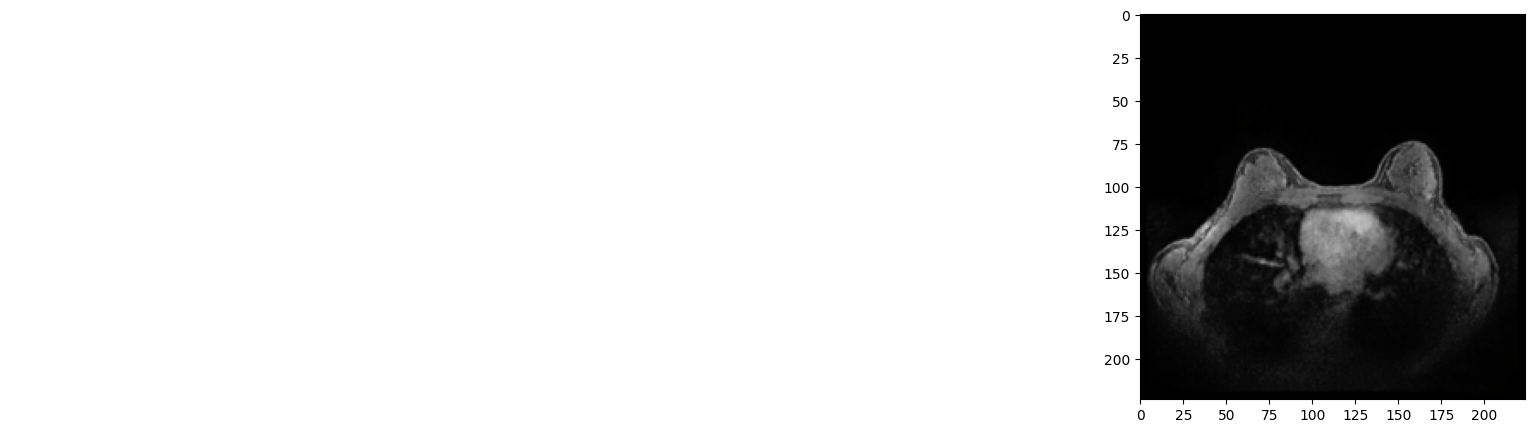

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to convert a Tensor to a NumPy array for plotting
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Example for iterating over the DataLoader
for i, (images, label) in enumerate(train_dataloader):
    # Check if we have already displayed the first batch of 4 sets of images
    if i >= 1:  # Since you mentioned only the first 4, we break after the first batch
        break

    # Remove batch dimension only if batch_size=1, and display the images
    images = images.squeeze(0)  # Assume images is of shape [1, 4, 3, 224, 224]

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # Prepare a row of 4 images
    for j in range(2):  # Assuming there are exactly 4 images per batch
        img = images[j]
        ax = axs[j]
        imshow(img.cpu())  # Make sure to move the tensor to 'cpu' if it's on 'cuda'
        ax.axis('off')
    plt.suptitle(f'Label: {label.item()}')
    plt.show()


### 5. Creating & Implementing Vision Transformer Model (from Hugging Face)

In [21]:
print(timm.list_models('vit*'))


['vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_reg1_gap_256', 'vit_base_patch16_rpn_224', 'vit_base_patch16_siglip_224', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_384', 'vit_base_patch16_siglip_512', 'vit_base_patch16_siglip_gap_224', 'vit_base_patch16_siglip_gap_256', 'vit_base_patch16_siglip_gap_384', 'vit_base_patch16_siglip_gap_512', 'vit_base_patch16_xp_224', 'vit_base_patch32_224', 'vit_base_patch32_384', 'vit_base_patch32_clip_224', 'vit_base_patch32_clip_256', 'vit_base_patch32_clip_384', 'vit_base_patch32_clip_448', 'vit_base_patch32_clip_quickgelu_224', 'vit_base_patch32_plus_256', 'vit_base_r26_s

In [22]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Train model

In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(vit_model.parameters(), lr=1e-4)

def train_model(dataloader, model, loss_fn, optimizer, epochs):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        for image_set, label in dataloader:
            # Since image_set is already in the shape [batch_size, channels, height, width],
            # no need to reshape if dataloader batch_size is 1
            image_set = image_set.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(image_set)
            loss = loss_fn(output, label)

            # Backward pass
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Start training

# Start training
train_model(train_dataloader, vit_model, loss_fn, optimizer, epochs=20)

Epoch 1, Loss: 0.28634509444236755
Epoch 2, Loss: 0.2837192714214325
Epoch 3, Loss: 0.17762579023838043
Epoch 4, Loss: 0.6923994421958923
Epoch 5, Loss: 0.4779081344604492
Epoch 6, Loss: 0.05190033093094826
Epoch 7, Loss: 0.241301491856575
Epoch 8, Loss: 0.6428453326225281
Epoch 9, Loss: 0.17698000371456146
Epoch 10, Loss: 0.07895241677761078
Epoch 11, Loss: 0.3817906677722931
Epoch 12, Loss: 0.28794795274734497
Epoch 13, Loss: 0.28247442841529846
Epoch 14, Loss: 0.5663807392120361
Epoch 15, Loss: 0.36222097277641296
Epoch 16, Loss: 0.23741459846496582
Epoch 17, Loss: 0.10509704798460007
Epoch 18, Loss: 0.35062119364738464
Epoch 19, Loss: 0.10761284828186035
Epoch 20, Loss: 0.07635463029146194


### 6. Using testing data

Use testing data

In [24]:
# Path to the directory containing the Breast MRI files
folder_path = '/content/drive/MyDrive/VLR_Project/pix2pix/post_3'

# List all files in the directory
file_list = os.listdir(folder_path)

# Create a filter mask for your DataFrame based on filenames present in the folder
mask = labels['Patient ID'].apply(lambda x: x + '.png' in file_list)  # Adjust '.extension' as needed

# Apply the mask to create the new filtered DataFrame
filtered_labels = labels[mask]

# Now, filtered_labels contains only the rows that match the files in your folder
print(filtered_labels)

         Patient ID Recurrence event(s)
0    Breast_MRI_001                   0
1    Breast_MRI_002                   0
2    Breast_MRI_003                   0
3    Breast_MRI_004                   0
4    Breast_MRI_005                   0
..              ...                 ...
917  Breast_MRI_918                   0
918  Breast_MRI_919                   0
919  Breast_MRI_920                   0
920  Breast_MRI_921                   0
921  Breast_MRI_922                   0

[913 rows x 2 columns]


In [25]:
class TestImageDataset(Dataset):
    def __init__(self, root_dir, labels_df, exclude_images):
        self.subdirs = ['post_3']
        self.root_dir = root_dir
        self.samples = []

        # Convert exclude_images to set for faster lookup
        exclude_images_set = set(exclude_images)

        # This list will keep the valid labels and their corresponding paths
        valid_labels = []
        valid_images = []

        # Iterate over subdirectories and collect valid images and labels
        for subdir in self.subdirs:
            full_path = os.path.join(root_dir, subdir)
            files_in_dir = os.listdir(full_path)

            # Filter and sort filenames to maintain consistent order
            filenames = sorted(f for f in files_in_dir if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff')))

            # Loop through filenames to build the dataset
            for filename in filenames:
                basename = os.path.splitext(filename)[0]
                if basename not in exclude_images_set:
                    valid_images.append(os.path.join(full_path, filename))

        # Exclude the labels for the excluded images
        # Assuming filenames without extension match the index order of labels
        valid_labels = [label for idx, label in enumerate(labels_df['Recurrence event(s)']) if labels_df['Patient ID'][idx] not in exclude_images_set]

        # Ensure each image has a corresponding label
        for img, lbl in zip(valid_images, valid_labels):
            self.samples.append((img, lbl))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = load_and_preprocess_image(image_path)
        return image, label

# Example usage
root_dir = '/content/drive/MyDrive/VLR_Project/pix2pix'
exclude_images = ['Breast_MRI_325', 'Breast_MRI_373']  # Define excluded image IDs
# labels_df = pd.DataFrame({
#     'ImageID': ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_325', 'Breast_MRI_373', 'Breast_MRI_005'],
#     'Recurrence event(s)': [0, 1, 0, 1, 0]
# })
labels_df = labels

t_dataset = TestImageDataset(root_dir, labels_df, exclude_images)
test_dataloader = DataLoader(t_dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
import torch
from torch.nn import functional as F

def evaluate_model(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    probabilities, true_labels = [], []

    with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # For AUC we need probability scores; the raw output from the last layer
            probs = torch.sigmoid(outputs).cpu().numpy()
            probabilities.extend(probs[:, 1])  # Assuming your model outputs logit for each class

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, probabilities, true_labels

# Then, use this function to get predictions and true labels
accuracy, probabilities, true_labels = evaluate_model(test_dataloader, vit_model)
print(f"Accuracy on test data: {accuracy*100:.2f}%")

Accuracy on test data: 88.47%


In [27]:
# Now calculate the AUC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(true_labels, probabilities)
print(f"AUC score: {auc_score:.2f}")

AUC score: 0.51


In [28]:
from sklearn.metrics import roc_curve, auc

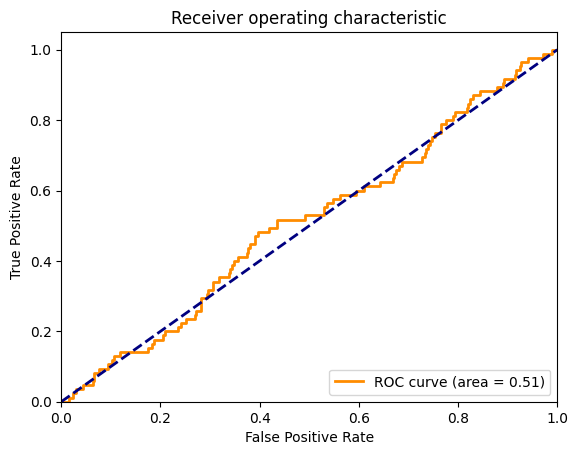

In [29]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [30]:
# Path to the directory containing the Breast MRI files
folder_path = '/content/drive/MyDrive/VLR_Project/diffusion/post_3'

# List all files in the directory
file_list = os.listdir(folder_path)

# Create a filter mask for your DataFrame based on filenames present in the folder
mask = labels['Patient ID'].apply(lambda x: x + '.png' in file_list)  # Adjust '.extension' as needed

# Apply the mask to create the new filtered DataFrame
filtered_labels = labels[mask]

# Now, filtered_labels contains only the rows that match the files in your folder
print(filtered_labels)

         Patient ID Recurrence event(s)
0    Breast_MRI_001                   0
1    Breast_MRI_002                   0
2    Breast_MRI_003                   0
3    Breast_MRI_004                   0
4    Breast_MRI_005                   0
..              ...                 ...
917  Breast_MRI_918                   0
918  Breast_MRI_919                   0
919  Breast_MRI_920                   0
920  Breast_MRI_921                   0
921  Breast_MRI_922                   0

[913 rows x 2 columns]


In [34]:
class TestImageDataset(Dataset):
    def __init__(self, root_dir, labels_df, exclude_images):
        self.subdirs = ['post_3']
        self.root_dir = root_dir
        self.samples = []

        # Convert exclude_images to set for faster lookup
        exclude_images_set = set(exclude_images)

        # This list will keep the valid labels and their corresponding paths
        valid_labels = []
        valid_images = []

        # Iterate over subdirectories and collect valid images and labels
        for subdir in self.subdirs:
            full_path = os.path.join(root_dir, subdir)
            files_in_dir = os.listdir(full_path)

            # Filter and sort filenames to maintain consistent order
            filenames = sorted(f for f in files_in_dir if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff')))

            # Loop through filenames to build the dataset
            for filename in filenames:
                basename = os.path.splitext(filename)[0]
                if basename not in exclude_images_set:
                    valid_images.append(os.path.join(full_path, filename))

        # Exclude the labels for the excluded images
        # Assuming filenames without extension match the index order of labels
        valid_labels = [label for idx, label in enumerate(labels_df['Recurrence event(s)']) if labels_df['Patient ID'][idx] not in exclude_images_set]

        # Ensure each image has a corresponding label
        for img, lbl in zip(valid_images, valid_labels):
            self.samples.append((img, lbl))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = load_and_preprocess_image(image_path)
        return image, label

# Example usage
root_dir = '/content/drive/MyDrive/VLR_Project/diffusion'
exclude_images = ['Breast_MRI_325', 'Breast_MRI_373']  # Define excluded image IDs
# labels_df = pd.DataFrame({
#     'ImageID': ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_325', 'Breast_MRI_373', 'Breast_MRI_005'],
#     'Recurrence event(s)': [0, 1, 0, 1, 0]
# })
labels_df = labels

t_dataset = TestImageDataset(root_dir, labels_df, exclude_images)
test_dataloader = DataLoader(t_dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
import torch
from torch.nn import functional as F

def evaluate_model(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    probabilities, true_labels = [], []

    with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # For AUC we need probability scores; the raw output from the last layer
            probs = torch.sigmoid(outputs).cpu().numpy()
            probabilities.extend(probs[:, 1])  # Assuming your model outputs logit for each class

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, probabilities, true_labels

# Then, use this function to get predictions and true labels
accuracy, probabilities, true_labels = evaluate_model(test_dataloader, vit_model)
print(f"Accuracy on test data: {accuracy*100:.2f}%")

Accuracy on test data: 89.76%


In [36]:
# Now calculate the AUC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(true_labels, probabilities)
print(f"AUC score: {auc_score:.2f}")

AUC score: 0.53


In [37]:
from sklearn.metrics import roc_curve, auc

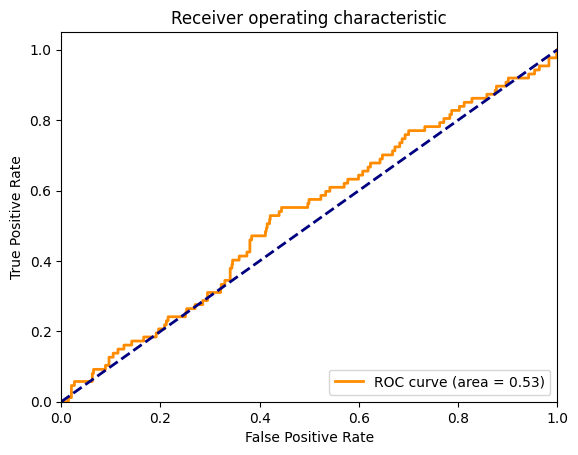

In [38]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
